In [1]:
import os
import pandas as pd
from pathlib import Path
import re
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import IPython.display as ipd

m:\anaconda\envs\alex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RAVDESS

path = 'datasets/archive/audio_speech_actors_01-24'

train_data = []
test_data = []
val_data = []

# Speaker split (gender-balanced)
train_speakers = ["01","03","05","07","09","11","13","15","17","02","04","06","08","10","12","14","16"]
val_speakers = ["19","20","18"]  # added validation split, took speakers form train split
test_speakers = ["21","23","22","24"]

emotion_map = {
    "01": "neutral",
    # "02": "calm",  -> remove not in crema-d
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    # "08": "surprised" -> remove not in crema-d
}

for folder in sorted(os.listdir(path)):
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
        match = re.match(r"(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)\.wav", file)
        if match:
            filepath = str(Path(path) / folder / file)
            indicators = match.groups()
            emotion_code = indicators[2]
            actor_id = indicators[-1]
            gender = 'Female' if int(indicators[-1]) % 2 == 0 else 'Male'
            if emotion_code not in emotion_map:
                continue

            record = {
                "path": filepath,
                "emotion": emotion_map[emotion_code],
                "gender": gender,
                "source": "RAVDESS"
            }

            if actor_id in train_speakers:
                train_data.append(record)
            elif actor_id in val_speakers:
                val_data.append(record)
            else:
                test_data.append(record)

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

In [3]:
train_df.shape

(748, 4)

In [4]:
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
print(demo_df.head(10))
print(demo_df.columns)

   ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic
5     1006   58  Female         Caucasian  Not Hispanic
6     1007   38  Female  African American  Not Hispanic
7     1008   46  Female         Caucasian  Not Hispanic
8     1009   24  Female         Caucasian  Not Hispanic
9     1010   27  Female         Caucasian  Not Hispanic
Index(['ActorID', 'Age', 'Sex', 'Race', 'Ethnicity'], dtype='object')


In [5]:
# CREMA-D

path = 'datasets/CREMA-D/AudioWAV'

# Load demographics for gender mapping
demo_df = pd.read_csv('datasets/CREMA-D/VideoDemographics.csv')
gender_map = dict(zip(demo_df['ActorID'], demo_df['Sex']))

# Check how many actors
print(f"Total actors: {len(gender_map)}")
print(f"Males: {list(gender_map.values()).count('Male')}")
print(f"Females: {list(gender_map.values()).count('Female')}")

Total actors: 91
Males: 48
Females: 43


In [6]:
train_data = []
test_data = []
val_data = []

emotion_map = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

# Get all actor IDs and split by gender
all_actors = demo_df['ActorID'].tolist()
male_actors = demo_df[demo_df['Sex'] == 'Male']['ActorID'].tolist()
female_actors = demo_df[demo_df['Sex'] == 'Female']['ActorID'].tolist()

# 80/20 split per gender
train_males = male_actors[:34]      # 34 males for train
val_males = male_actors[34:38]      # 4 males for validation
test_males = male_actors[38:]       # 10 males for test

train_females = female_actors[:34]  # 34 females for train  
val_females = female_actors[34:38]  # 4 females for validation
test_females = female_actors[38:]   # 5 females for test

train_speakers = train_males + train_females  # 72 speakers
val_speakers = val_males + val_females        # 8 speakers
test_speakers = test_males + test_females      # 19 speakers

print(f"\nTrain speakers: {len(train_speakers)} ({len(train_males)}M, {len(train_females)}F)")
print(f"Validation speakers: {len(val_speakers)} ({len(val_males)}M, {len(val_females)}F)")
print(f"Test speakers: {len(test_speakers)} ({len(test_males)}M, {len(test_females)}F)")

# Parse audio files
for file in os.listdir(path):
    if not file.endswith('.wav'):
        continue
        
    # Filename: 1001_IEO_ANG_HI.wav
    parts = file.replace('.wav', '').split('_')
    
    if len(parts) < 4:
        continue
    
    actor_id = int(parts[0])
    emotion_code = parts[2]
    
    if emotion_code not in emotion_map:
        continue
    
    filepath = str(Path(path) / file)
    gender = gender_map.get(actor_id, 'Unknown')
    
    record = {
        "path": filepath,
        "emotion": emotion_map[emotion_code],
        "gender": gender,
        "source": "CREMA-D"
    }
    
    if actor_id in train_speakers:
        train_data.append(record)
    elif actor_id in val_speakers:
        val_data.append(record)
    elif actor_id in test_speakers:
        test_data.append(record)

# Create DataFrames
train_df_cremad = pd.DataFrame(train_data)
val_df_cremad = pd.DataFrame(val_data)
test_df_cremad = pd.DataFrame(test_data)

# Verify
print("\nCREMA-D TRAIN:")
print(f"  Samples: {len(train_df_cremad)}")
print(f"  By gender: {train_df_cremad['gender'].value_counts().to_dict()}")

print("\nCREMA-D VALIDATION:")
print(f"  Samples: {len(val_df_cremad)}")
print(f" by gender: {val_df_cremad['gender'].value_counts().to_dict()}")

print("\nCREMA-D TEST:")
print(f"  Samples: {len(test_df_cremad)}")
print(f"  By gender: {test_df_cremad['gender'].value_counts().to_dict()}")


Train speakers: 68 (34M, 34F)
Validation speakers: 8 (4M, 4F)
Test speakers: 15 (10M, 5F)

CREMA-D TRAIN:
  Samples: 5557
  By gender: {'Male': 2782, 'Female': 2775}

CREMA-D VALIDATION:
  Samples: 655
 by gender: {'Male': 328, 'Female': 327}

CREMA-D TEST:
  Samples: 1230
  By gender: {'Male': 820, 'Female': 410}


In [7]:
train_df_combined = pd.concat([train_df, train_df_cremad], ignore_index=True)
val_df_combined = pd.concat([val_df, val_df_cremad], ignore_index=True)
test_df_combined = pd.concat([test_df, test_df_cremad], ignore_index=True)

train_df_combined.to_csv("train_split.csv", index=False)
val_df_combined.to_csv("val_split.csv", index=False)
test_df_combined.to_csv("test_split.csv", index=False)

print(f"\nFINAL TRAIN: {len(train_df_combined)}")
print(f"FINAL VALIDATION: {len(val_df_combined)}")
print(f"FINAL TEST: {len(test_df_combined)}")


FINAL TRAIN: 6305
FINAL VALIDATION: 787
FINAL TEST: 1406


In [8]:
class EmotionDataset(Dataset):
    def __init__(self, csv_path, augment=False):
        self.df = pd.read_csv(csv_path)
        self.augment = augment
        
        self.emotion_to_idx = {
            'angry': 0,
            'disgust': 1,
            'fearful': 2,
            'happy': 3,
            'neutral': 4,
            'sad': 5
        }
        
        # wav2vec2 expects 16kHz
        self.sample_rate = 16000
        self.duration = 5
        self.target_length = self.sample_rate * self.duration  # 80000
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. Load audio at 16kHz (wav2vec2 requirement)
        waveform, sr = librosa.load(row['path'], sr=self.sample_rate, mono=True)
        
        # 2. Fix length to exactly 5 seconds
        if len(waveform) < self.target_length:
            padding = self.target_length - len(waveform)
            offset = padding // 2
            waveform = np.pad(waveform, (offset, padding - offset), 'constant')
        else:
            waveform = waveform[:self.target_length]
        
        # 3. Augmentation
        if self.augment:
            if np.random.random() < 0.5:
                shift = np.random.randint(-1600, 1600)
                waveform = np.roll(waveform, shift)
            
            if np.random.random() < 0.5:
                noise = np.random.normal(0, 0.003, waveform.shape)
                waveform = waveform + noise
            
            if np.random.random() < 0.5:
                volume = np.random.uniform(0.9, 1.1)
                waveform = waveform * volume
        
        # 4. Convert to tensor — raw waveform, no feature extraction
        waveform_tensor = torch.FloatTensor(waveform)
        
        # 5. Get label
        label = self.emotion_to_idx[row['emotion']]
        
        return waveform_tensor, label

In [9]:
class Wav2Vec2EmotionClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        
        # Freeze the feature extractor, fine-tune the transformer
        self.wav2vec2.feature_extractor._freeze_parameters()
        
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # was 0.3
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_values):
        # input_values: raw waveform at 16kHz
        outputs = self.wav2vec2(input_values)
        # Mean pool over time dimension
        hidden_states = outputs.last_hidden_state  # (batch, time, 768)
        pooled = hidden_states.mean(dim=1)          # (batch, 768)
        return self.classifier(pooled)

In [10]:
# class Wav2Vec2EmotionClassifier(nn.Module):
#     def __init__(self, num_classes=6):
#         super().__init__()
        
#         # Load pretrained wav2vec2-base
#         self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        
#         # Freeze everything first
#         for param in self.wav2vec2.parameters():
#             param.requires_grad = False

#         # Unfreeze last 4 transformer layers
#         for layer in self.wav2vec2.encoder.layers[-4:]:
#             for param in layer.parameters():
#                 param.requires_grad = True
        
#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(768, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
    
#     def forward(self, input_values):
#         # input_values shape: (batch, 80000) raw waveform
#         outputs = self.wav2vec2(input_values)
#         hidden_states = outputs.last_hidden_state  # (batch, ~249, 768)
        
#         # Mean pool over time
#         pooled = hidden_states.mean(dim=1)  # (batch, 768)
        
#         return self.classifier(pooled)

In [11]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.early_stop

In [12]:
def train_model(model, train_loader, validation_loader, epochs=50, lr=0.001, patience=10, device='cuda', weight_decay=1e-4):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    early_stopping = EarlyStopping(patience=patience)
    
    best_acc = 0.0
    best_model_state = None
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        
        # Testing
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(validation_loader)
        scheduler.step(val_loss)
        
        # Save history
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # Early stopping check
        if early_stopping(val_loss):
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return best_acc, history

In [13]:
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import os

def offline_augment(csv_path, output_dir, sr=16000, duration=5):
    df = pd.read_csv(csv_path)
    os.makedirs(output_dir, exist_ok=True)
    
    new_rows = []
    target_length = sr * duration
    
    for idx, row in df.iterrows():
        waveform, _ = librosa.load(row['path'], sr=sr, mono=True)
        
        if len(waveform) < target_length:
            padding = target_length - len(waveform)
            offset = padding // 2
            waveform = np.pad(waveform, (offset, padding - offset), 'constant')
        else:
            waveform = waveform[:target_length]
        
        # Augmentation 1: noise
        noisy = waveform + np.random.normal(0, 0.005, waveform.shape)
        path_noise = os.path.join(output_dir, f"aug_noise_{idx}.wav")
        sf.write(path_noise, noisy, sr)
        new_rows.append({'path': path_noise, 'emotion': row['emotion'], 
                        'gender': row['gender'], 'source': row['source']})
        
        # Augmentation 2: pitch shift
        pitched = librosa.effects.pitch_shift(waveform, sr=sr, n_steps=np.random.uniform(-2, 2))
        path_pitch = os.path.join(output_dir, f"aug_pitch_{idx}.wav")
        sf.write(path_pitch, pitched, sr)
        new_rows.append({'path': path_pitch, 'emotion': row['emotion'], 
                        'gender': row['gender'], 'source': row['source']})
    
    # Combine original + augmented
    aug_df = pd.DataFrame(new_rows)
    combined = pd.concat([df, aug_df], ignore_index=True)
    combined.to_csv("train_split_augmented.csv", index=False)
    
    print(f"Original: {len(df)} → Augmented: {len(combined)}")
    return combined

offline_augment('train_split.csv', 'augmented_audio/')

Original: 6305 → Augmented: 18915


,path,emotion,gender,source
0,datasets\archive\audio_speech_actors_01-24\Act...,neutral,Male,RAVDESS
1,datasets\archive\audio_speech_actors_01-24\Act...,neutral,Male,RAVDESS
2,datasets\archive\audio_speech_actors_01-24\Act...,neutral,Male,RAVDESS
3,datasets\archive\audio_speech_actors_01-24\Act...,neutral,Male,RAVDESS
4,datasets\archive\audio_speech_actors_01-24\Act...,happy,Male,RAVDESS
...,...,...,...,...
18910,augmented_audio/aug_pitch_6302.wav,happy,Female,CREMA-D
18911,augmented_audio/aug_noise_6303.wav,neutral,Female,CREMA-D
18912,augmented_audio/aug_pitch_6303.wav,neutral,Female,CREMA-D
18913,augmented_audio/aug_noise_6304.wav,sad,Female,CREMA-D


In [14]:
# Datasets
train_dataset = EmotionDataset('train_split_augmented.csv', augment=False)  # offline augmented, no on-the-fly
validation_dataset = EmotionDataset('val_split.csv', augment=False)
test_dataset = EmotionDataset('test_split.csv', augment=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(validation_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 18915 samples
Validation: 787 samples
Test: 1406 samples


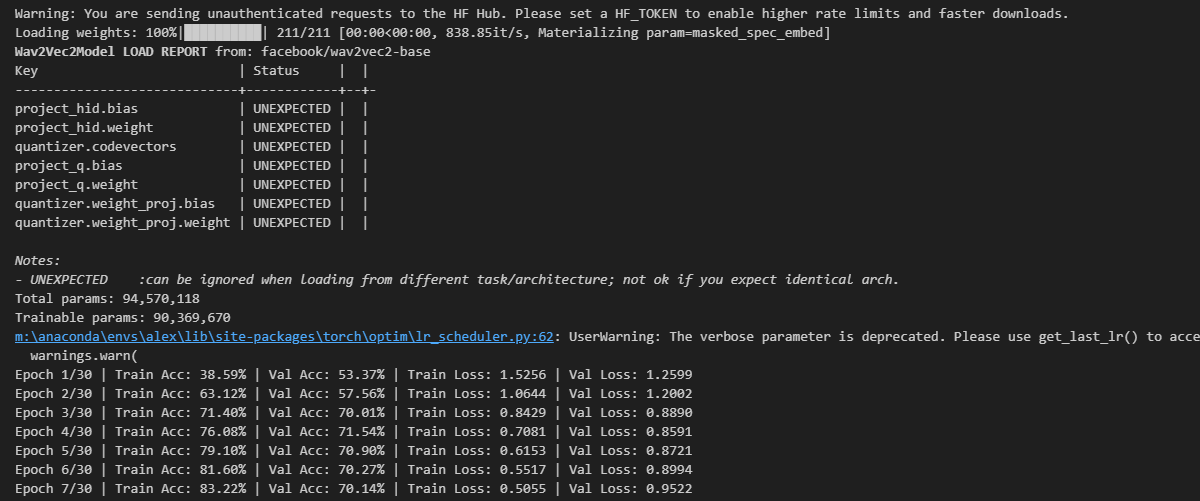

In [15]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Wav2Vec2EmotionClassifier(num_classes=6).to(device)

# Print param counts
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

# Train — lower LR since we're fine-tuning a pretrained model
best_acc, history = train_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=15,
    # lr=5e-6,          # lower LR for fine-tuning
    lr=1e-5,          
    patience=6,
    device=device,
    weight_decay=1e-4
)

print(f"Best Accuracy: {best_acc:.2f}%")

Loading weights: 100%|██████████| 211/211 [00:00<00:00, 1031.51it/s, Materializing param=masked_spec_embed]                                           
Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
quantizer.codevectors        | UNEXPECTED |  | 
project_hid.weight           | UNEXPECTED |  | 
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 
quantizer.weight_proj.weight | UNEXPECTED |  | 
project_hid.bias             | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Total params: 94,570,118
Trainable params: 90,369,670


m:\anaconda\envs\alex\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Train Acc: 53.89% | Val Acc: 69.89% | Train Loss: 1.2268 | Val Loss: 0.8905
Epoch 2/15 | Train Acc: 74.37% | Val Acc: 73.44% | Train Loss: 0.7603 | Val Loss: 0.7870
Epoch 3/15 | Train Acc: 80.43% | Val Acc: 71.79% | Train Loss: 0.5802 | Val Loss: 0.8136
Epoch 4/15 | Train Acc: 84.46% | Val Acc: 70.14% | Train Loss: 0.4645 | Val Loss: 1.0108
Epoch 5/15 | Train Acc: 87.59% | Val Acc: 71.28% | Train Loss: 0.3767 | Val Loss: 0.9894
Epoch 6/15 | Train Acc: 89.82% | Val Acc: 73.57% | Train Loss: 0.3106 | Val Loss: 1.0118
Epoch 7/15 | Train Acc: 91.57% | Val Acc: 73.57% | Train Loss: 0.2609 | Val Loss: 1.0197
Epoch 8/15 | Train Acc: 92.86% | Val Acc: 72.55% | Train Loss: 0.2233 | Val Loss: 1.2084
  Early stopping at epoch 8
Best Accuracy: 73.57%


In [16]:
torch.save(model.state_dict(), "model/best_model.pth")
print(f"Model saved with best val accuracy: {best_acc:.2f}%")

Model saved with best val accuracy: 73.57%


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("model/best_model.pth", map_location=device))
model.to(device)
model.eval()

# Test loop
all_preds = []
all_labels = []

with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
test_loss = test_loss / len(test_loader)
print(f"Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

Test Accuracy: 70.77% | Test Loss: 1.2602


In [20]:
# Classification report
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # adjust to your labels
print("\n", classification_report(all_labels, all_preds, target_names=emotion_labels))


               precision    recall  f1-score   support

       angry       0.74      0.93      0.82       242
     disgust       0.90      0.52      0.66       242
        fear       0.81      0.45      0.58       242
       happy       0.83      0.82      0.83       242
     neutral       0.57      0.94      0.71       196
         sad       0.57      0.62      0.60       242

    accuracy                           0.71      1406
   macro avg       0.74      0.72      0.70      1406
weighted avg       0.74      0.71      0.70      1406



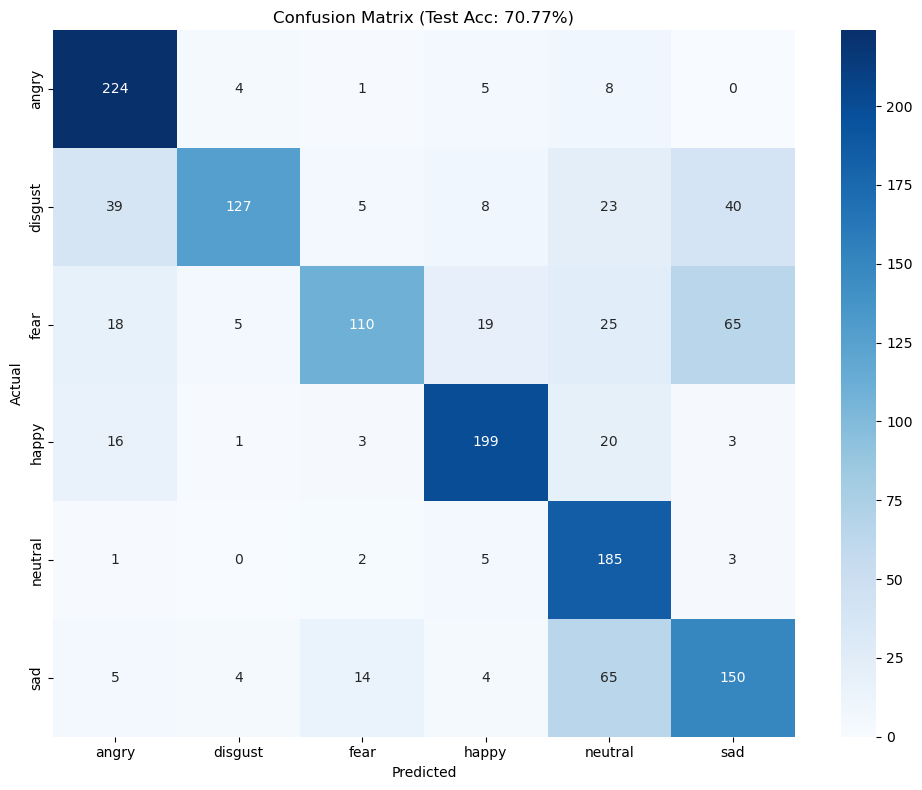

In [21]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Acc: {test_acc:.2f}%)')
plt.tight_layout()
plt.show()